# Reliance Stock Analysis & Prediction Notebook

This notebook performs:
1. Data download & cleaning (via `yfinance`)
2. Visualizations with **matplotlib**
3. Technical indicators (moving averages, returns, volatility)
4. **scikit-learn** models (Linear Regression, Random Forest)
5. **Prophet** time-series forecast (optional, with fallback)
6. **LSTM** deep learning prediction (TensorFlow/Keras)

**Note:** Install required packages if missing. Cells include safe fallbacks so the notebook still runs if some libraries aren't available.

## 0. Setup & Imports

In [1]:
# If needed, uncomment to install locally in your Jupyter environment:
# %pip install yfinance pandas numpy matplotlib scikit-learn mplfinance
# %pip install prophet  # optional; may require build tools (cmdstan)
# %pip install tensorflow  # optional for LSTM

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# Optional/extra packages with safe imports
try:
    import yfinance as yf
except Exception as e:
    raise RuntimeError("yfinance is required. Please install with: %pip install yfinance") from e

try:
    import mplfinance as mpf
    HAS_MPLFINANCE = True
except Exception:
    HAS_MPLFINANCE = False

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Prophet (optional)
try:
    from prophet import Prophet
    HAS_PROPHET = True
except Exception:
    HAS_PROPHET = False

# TensorFlow/Keras (optional)
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Dropout
    from sklearn.preprocessing import MinMaxScaler
    HAS_TF = True
except Exception:
    HAS_TF = False

print("Versions -> pandas:", pd.__version__, "| numpy:", np.__version__)


Versions -> pandas: 2.3.1 | numpy: 2.3.2


## 1. Download Reliance Data

In [2]:
TICKER = "^NSEI"  # NSE: Nifty 50
START = "2024-01-01"
END = None  # None = up to today

df = yf.download(TICKER, start=START, end=END, auto_adjust=True)
if df.empty:
    raise RuntimeError("No data downloaded. Check ticker or internet connection.")

# Basic checks
display(df.head())
display(df.tail())
print("Shape:", df.shape)
print("Date range:", df.index.min().date(), "->", df.index.max().date())

# Keep a copy
raw_df = df.copy()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
Date,,,,,
2024-01-01,21741.900391,21834.349609,21680.849609,21727.750000,154000
2024-01-02,21665.800781,21755.599609,21555.650391,21751.349609,263700
2024-01-03,21517.349609,21677.000000,21500.349609,21661.099609,311900
2024-01-04,21658.599609,21685.650391,21564.550781,21605.800781,339200
2024-01-05,21710.800781,21749.599609,21629.199219,21705.750000,309300


Price,Close,High,Low,Open,Volume
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
Date,,,,,
2025-08-14,24631.300781,24673.650391,24596.900391,24607.250000,270200
2025-08-18,24876.949219,25022.000000,24852.849609,24938.199219,363100
2025-08-19,24980.650391,25012.650391,24873.949219,24891.349609,252300
2025-08-20,25050.550781,25088.699219,24929.699219,24965.800781,287100
2025-08-21,25132.949219,25145.699219,25054.900391,25142.000000,0


Shape: (406, 5)
Date range: 2024-01-01 -> 2025-08-21


## 2. Feature Engineering & Indicators

In [3]:
df = raw_df.copy()

# Daily returns
df['Return'] = df['Close'].pct_change()

# Moving averages
df['MA20'] = df['Close'].rolling(20).mean()
df['MA50'] = df['Close'].rolling(50).mean()
df['MA200'] = df['Close'].rolling(200).mean()

# Rolling volatility (21-day, annualized)
df['Volatility21'] = df['Return'].rolling(21).std() * np.sqrt(252)

# Drop initial NaNs for indicators
df = df.dropna()
display(df.head())


Price,Close,High,Low,Open,Volume,Return,MA20,MA50,MA200,Volatility21
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI,,,,,
Date,,,,,,,,,,
2024-10-23,24435.500000,24604.250000,24378.099609,24378.150391,284600,-0.001496,25173.717383,25122.100937,23346.332197,0.119074
2024-10-24,24399.400391,24480.650391,24341.199219,24412.699219,216700,-0.001477,25093.479883,25127.308945,23359.619697,0.118727
2024-10-25,24180.800781,24440.250000,24073.900391,24418.050781,372600,-0.008959,24991.717383,25128.049961,23372.194697,0.118841
2024-10-28,24339.150391,24492.599609,24134.900391,24251.099609,278600,0.006549,24899.727441,25124.009961,23386.303701,0.116992
2024-10-29,24466.849609,24484.500000,24140.849609,24328.849609,332000,0.005247,24832.527441,25121.893945,23400.344951,0.120708


## 3. Visualizations (Matplotlib)

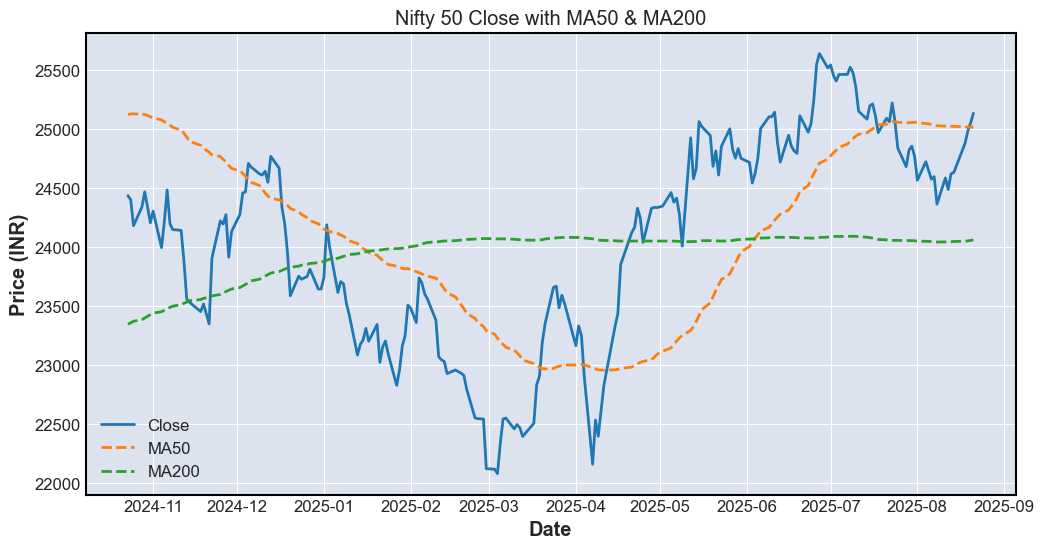

In [13]:
# Close with MAs
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label='Close')
plt.plot(df.index, df['MA50'], label='MA50', linestyle='--')
plt.plot(df.index, df['MA200'], label='MA200', linestyle='--')
plt.title('Nifty 50 Close with MA50 & MA200')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.show()


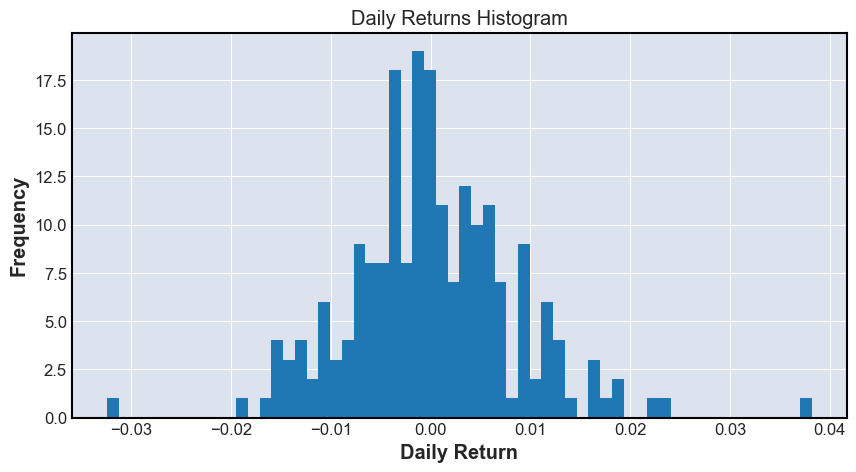

In [14]:
# Daily return distribution (histogram)
plt.figure(figsize=(10,5))
plt.hist(df['Return'].dropna(), bins=60)
plt.title('Daily Returns Histogram')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


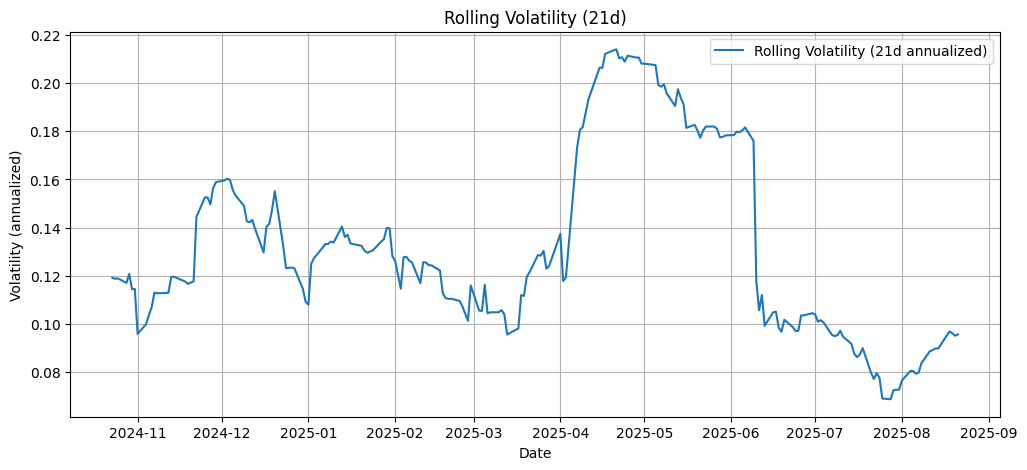

In [6]:
# Volatility
plt.figure(figsize=(12,5))
plt.plot(df.index, df['Volatility21'], label='Rolling Volatility (21d annualized)')
plt.title('Rolling Volatility (21d)')
plt.xlabel('Date')
plt.ylabel('Volatility (annualized)')
plt.legend()
plt.grid(True)
plt.show()


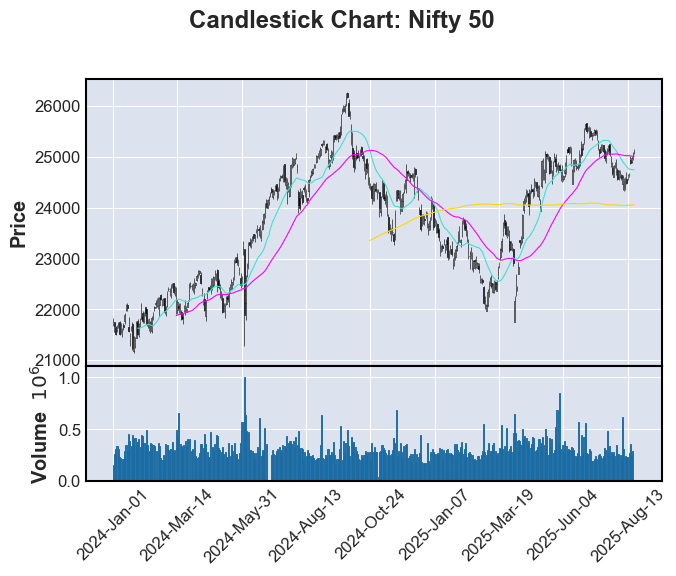

In [15]:
# Optional candlestick chart with mplfinance
if HAS_MPLFINANCE:
    # Flatten columns if multi-index and rename to standard OHLCV
    df_mpf = raw_df.copy()
    if isinstance(df_mpf.columns, pd.MultiIndex):
        df_mpf.columns = [col[0] for col in df_mpf.columns]
    df_mpf = df_mpf.rename(columns={
        'Open': 'Open',
        'High': 'High',
        'Low': 'Low',
        'Close': 'Close',
        'Volume': 'Volume'
    })
    # Ensure all columns are float/int
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df_mpf[col] = pd.to_numeric(df_mpf[col], errors='coerce')
    mpf.plot(df_mpf, type='candle', volume=True, mav=(20,50,200), title='Candlestick Chart: Nifty 50')
else:
    print("mplfinance not installed; skipping candlestick chart.")


## 4. scikit-learn Models (Next-day Price Prediction)
We train models to predict **next day's Close** using current day's features.

Linear Regression -> RMSE: 198.32751755196048 | R2: 0.6698939215869801
Random Forest     -> RMSE: 305.16258056412676 | R2: 0.2184619497507312


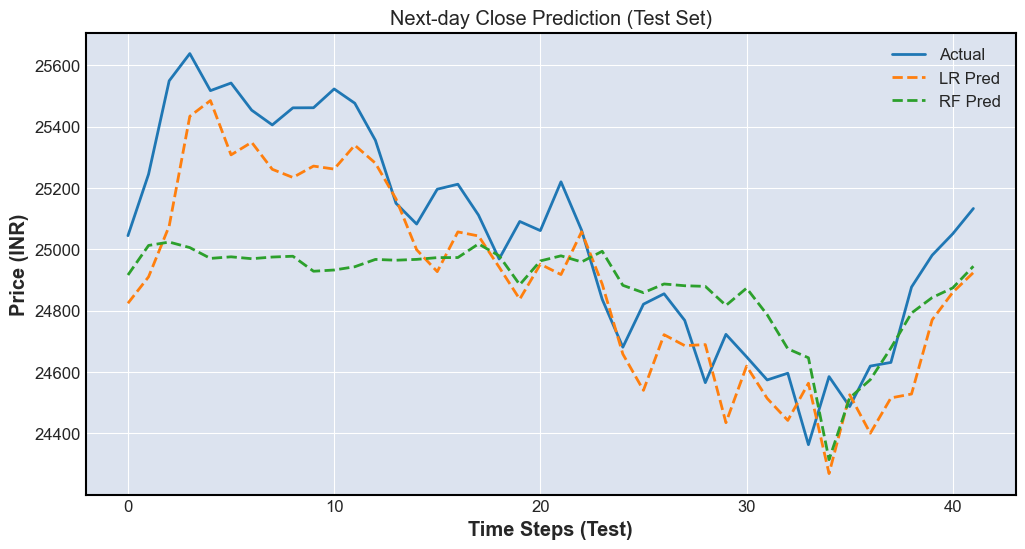

In [8]:
# Prepare supervised learning dataset
data_ml = df.copy()
data_ml['Target'] = data_ml['Close'].shift(-1)  # next day's close
data_ml = data_ml.dropna()

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA20', 'MA50', 'MA200', 'Volatility21']
X = data_ml[features].values
y = data_ml['Target'].values

# Time-aware split (no shuffling)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

# Metrics
def rmse(a, b): return float(np.sqrt(mean_squared_error(a, b)))

print("Linear Regression -> RMSE:", rmse(y_test, pred_lr), "| R2:", r2_score(y_test, pred_lr))
print("Random Forest     -> RMSE:", rmse(y_test, pred_rf), "| R2:", r2_score(y_test, pred_rf))

# Plot predictions vs actual
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual')
plt.plot(pred_lr, label='LR Pred', linestyle='--')
plt.plot(pred_rf, label='RF Pred', linestyle='--')
plt.title('Next-day Close Prediction (Test Set)')
plt.xlabel('Time Steps (Test)')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.show()


## 5. Prophet Forecast (Optional)
Forecasts future values based on historical Close price. Skips gracefully if Prophet isn't available.

10:47:47 - cmdstanpy - INFO - Chain [1] start processing
10:47:48 - cmdstanpy - INFO - Chain [1] done processing


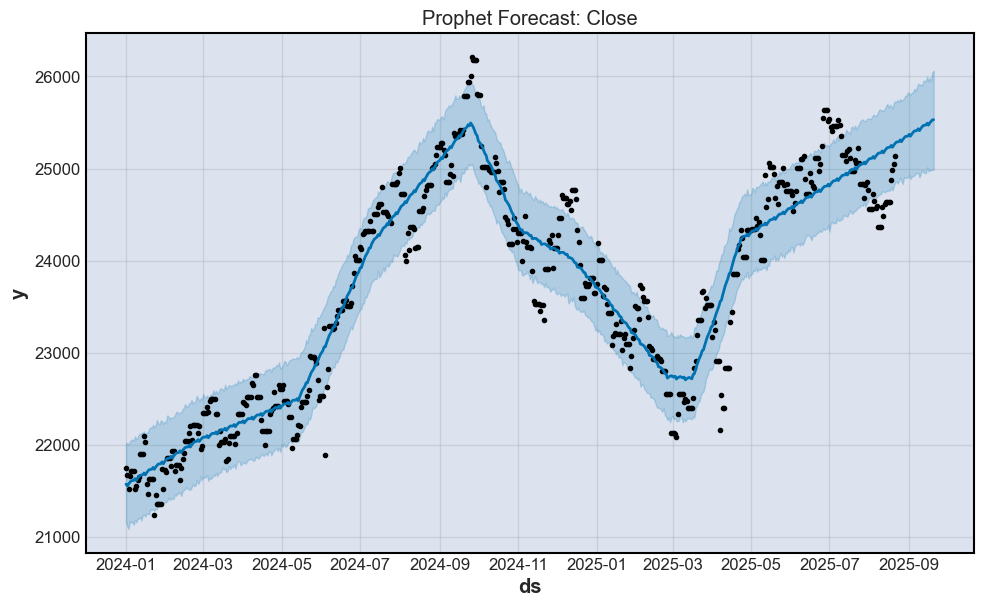

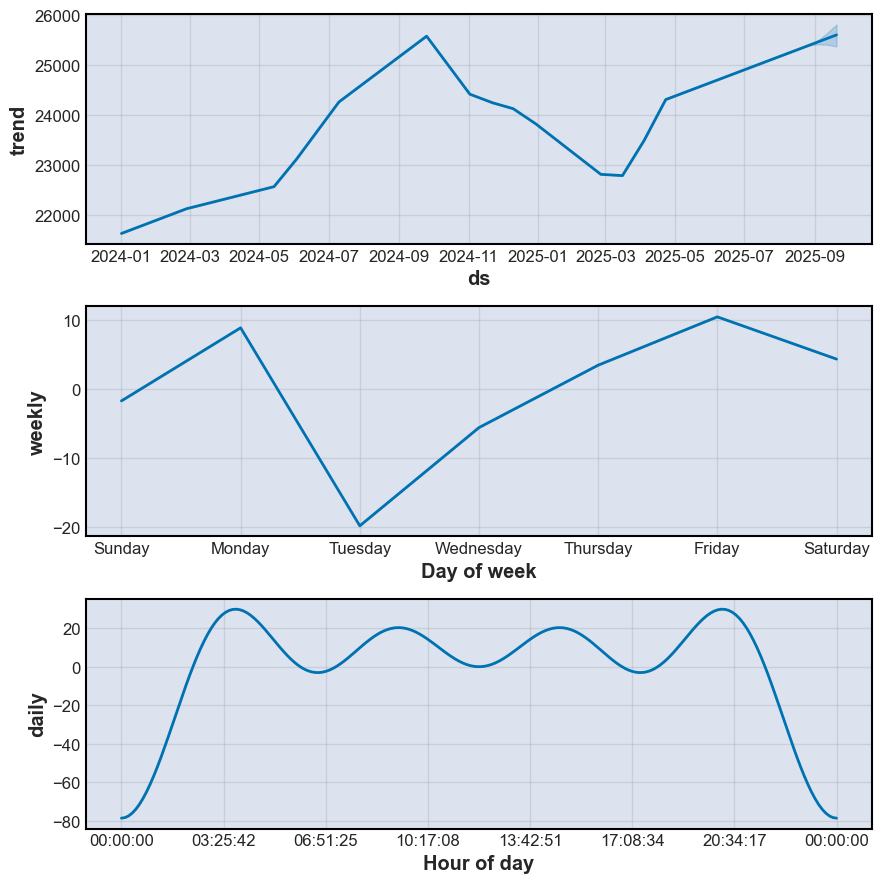

In [9]:
if HAS_PROPHET:
    # Flatten columns if multi-index
    df_flat = raw_df.copy()
    if isinstance(df_flat.columns, pd.MultiIndex):
        df_flat.columns = [col[0] for col in df_flat.columns]
    df_p = df_flat.reset_index()[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
    # Prophet prefers daily frequency and may need no missing dates
    # Reindex to daily freq and forward-fill
    df_p = df_p.set_index('ds').asfreq('D').ffill().reset_index()

    m = Prophet(daily_seasonality=True)
    m.fit(df_p)

    future = m.make_future_dataframe(periods=30)  # forecast next 30 days
    forecast = m.predict(future)

    fig1 = m.plot(forecast)
    fig1.gca().set_title('Prophet Forecast: Close')
    plt.show()

    fig2 = m.plot_components(forecast)
    plt.show()
else:
    print("Prophet is not installed; skipping Prophet forecast. Install with: %pip install prophet")


## 6. LSTM Deep Learning Model 
Sequence model using the last 60 days of Close to predict next day Close. Skips gracefully if TensorFlow isn't available.

Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - loss: 0.0661
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0191
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0144
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0102
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0099
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0106
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0094
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0098
Epoch 9/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0099
Epoch 10/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0103
Epoch 11/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.0092
Epoch 12/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - loss: 0.0095
Epoch 13/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 0.0091
Epoch 14/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0089
Epoch 15/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 0.0085
3/3 ━━━━━━━━━━━━━━━━━━━━ 

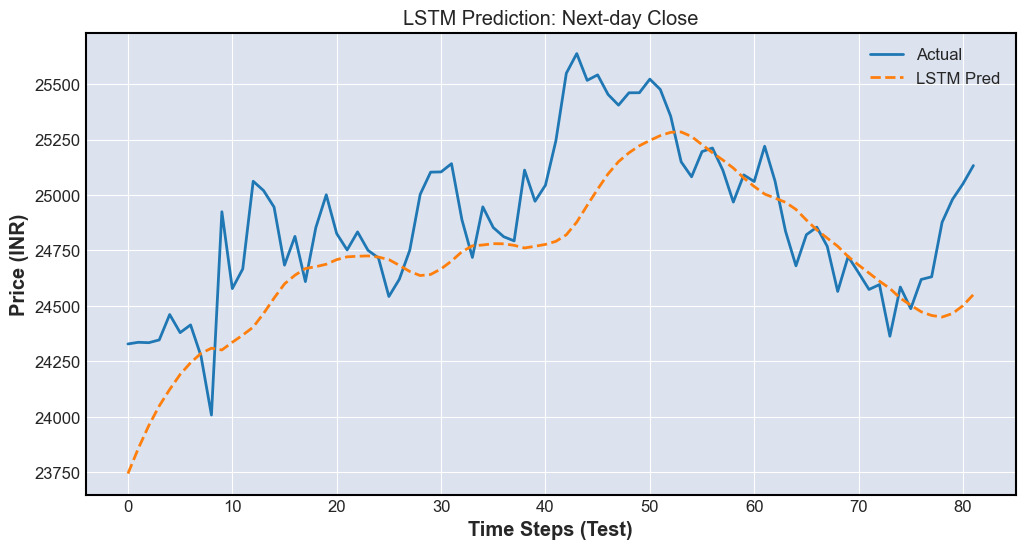

In [10]:
if HAS_TF:
    close_series = raw_df[['Close']].copy()

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(close_series)

    lookback = 60
    split = int(len(scaled)*0.8)
    train_data = scaled[:split]
    test_data = scaled[split - lookback:]

    def make_sequences(arr, lb):
        Xs, ys = [], []
        for i in range(lb, len(arr)):
            Xs.append(arr[i-lb:i, 0])
            ys.append(arr[i, 0])
        Xs, ys = np.array(Xs), np.array(ys)
        return Xs.reshape((Xs.shape[0], Xs.shape[1], 1)), ys

    X_train, y_train = make_sequences(train_data, lookback)
    X_test, y_test_scaled = make_sequences(test_data, lookback)

    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(lookback,1)),
        Dropout(0.2),
        LSTM(64, return_sequences=False),
        Dropout(0.2),
        Dense(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=15, batch_size=32, verbose=1)

    # Predict and inverse transform
    pred_scaled = model.predict(X_test)
    pred = scaler.inverse_transform(pred_scaled)
    y_true = close_series.iloc[split:].values  # true unscaled

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(y_true, label='Actual')
    plt.plot(pred, label='LSTM Pred', linestyle='--')
    plt.title('LSTM Prediction: Next-day Close')
    plt.xlabel('Time Steps (Test)')
    plt.ylabel('Price (INR)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("TensorFlow not installed; skipping LSTM. Install with: %pip install tensorflow")


## 7. Save Processed Data

In [16]:
out_csv = "Nifty_50_processed.csv"
df.to_csv(out_csv)
print(f"Saved engineered dataset to {out_csv}")


Saved engineered dataset to Nifty_50_processed.csv


## 8. Notes
- All charts use matplotlib. If you prefer interactive charts, consider Plotly.
- Model results are **illustrative**, not financial advice.
- Improve models with more features (technical indicators, macro variables), hyperparameter tuning, and walk-forward validation.

In [17]:
# ## 9. Generate PDF Report
# This cell generates a PDF report with key stats and charts.

# !pip install reportlab

%pip install reportlab

from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image as RLImage
from reportlab.lib.pagesizes import letter
from reportlab.lib.styles import getSampleStyleSheet

# File name for PDF
pdf_filename = (f"{TICKER}.pdf")
doc = SimpleDocTemplate(pdf_filename, pagesize=letter)
styles = getSampleStyleSheet()
elements = []

# Title
elements.append(Paragraph("Nifty 50 Stock Analysis Report", styles['Title']))
elements.append(Spacer(1, 12))

# Date Range & Stats
elements.append(Paragraph(f"Date Range: {df.index.min().date()} to {df.index.max().date()}", styles['Normal']))
elements.append(Paragraph(f"Total Data Points: {len(df)}", styles['Normal']))
latest_close = df['Close'].iloc[-1]
if hasattr(latest_close, "item"):
    latest_close = latest_close.item()
elements.append(Paragraph(f"Latest Close Price: {latest_close:.2f} INR", styles['Normal']))
elements.append(Spacer(1, 12))

# Save and add charts
def save_plot(fig, filename):
    fig.savefig(filename, bbox_inches='tight')
    plt.close(fig)
    elements.append(RLImage(filename, width=400, height=200))
    elements.append(Spacer(1, 12))

# Chart 1: Closing Price with MA
fig1 = plt.figure(figsize=(8,4))
plt.plot(df.index.values, df['Close'].values, label='Close')
plt.plot(df.index.values, df['MA50'].values, label='MA50', linestyle='--')
plt.plot(df.index.values, df['MA200'].values, label='MA200', linestyle='--')
plt.title('Closing Price with MA50 & MA200')
plt.legend()
save_plot(fig1, "close_ma_chart.png")

# Chart 2: Volatility
fig2 = plt.figure(figsize=(8,4))
plt.plot(df.index.values, df['Volatility21'].values, label='Volatility (21d)')
plt.title('Rolling Volatility (21d Annualized)')
plt.legend()
save_plot(fig2, "volatility_chart.png")

# Chart 3: Predictions (if available)
try:
    fig3 = plt.figure(figsize=(8,4))
    plt.plot(y_test, label='Actual')
    plt.plot(pred_rf, label='RF Pred', linestyle='--')
    plt.title('Random Forest Prediction (Test Set)')
    plt.legend()
    save_plot(fig3, "prediction_chart.png")
except Exception as e:
    print("Skipping prediction chart in PDF:", e)

# Build PDF
doc.build(elements)
print(f"PDF report generated: {pdf_filename}")


Note: you may need to restart the kernel to use updated packages.
PDF report generated: ^NSEI.pdf
